## Imports & Constants

In [1]:
import datetime
import gtab
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
from matplotlib.font_manager import FontProperties
from matplotlib import cm
import math
import numpy as np
import pandas as pd
import pickle
import os
import seaborn as sns
import statsmodels.formula.api as smf

In [2]:
PRISM_DATE = datetime.datetime(2013, 6, 6)
# GTAB information
TERROR_FILE = 'google_terrorism.obj'
DOMESTIC_FILE = 'google_domestic.obj'
TIMEFRAME = '2011-01-01 2015-12-31'
ANCHORBANK = 'google_anchorbank_geo=_timeframe=' + TIMEFRAME + '.tsv'
GTAB_DIR = './gtab'
ANCHORBANK_LOCATION = os.path.join(GTAB_DIR, 'output/google_anchorbanks', ANCHORBANK)

## Utility functions

### Make figure
A plotting function that takes a dataframe with an indexed grouped by month and a column containing information to plot. It will create a plot similar to Figure 2 in the paper "Chilling Effects ..."

In [32]:
def split_timeseries_figures(in_frames, names, split_at=PRISM_DATE, same_plot=True, **kwargs):
    """
    Takes the input data and creates a plot similar to figure 4a in the paper.
    :param dataframes: An iterable of 2 pandas data frames with the dates (dtype=PeriodIndex) as index and views as only column
    :param names: Names for the incoming data frames (neede for the legend)
    :param split_at: The date at which the data shall be split
    :param same_plot: If set false, a subplot will be created for each dataframe in in_frames. If true, they will be plotted on the same axis.
    :return: Plots the figure
    """
    
    # Default values that can be changed
    title = kwargs.get('title', '')
    figsize = kwargs.get('figsize', [18, 6])
    keyword = kwargs.get('keyword', 'views')
    sharey = kwargs.get('sharey', True)
    show_legend = kwargs.get('legend', True) and same_plot
    
    # Make sure we can iterate over the input argument to get a constant behavior, even if there is only 1df given.
    if isinstance(in_frames, pd.DataFrame):
        in_frames = [in_frames]
    if isinstance(names, str):
        names = [names]
    assert len(names) == len(in_frames), "{} dataframes but {} names specified. This should be equal".format(len(in_frames), len(names))
    nr_subplots = len(in_frames)
    same_plot = True if nr_subplots == 1 else same_plot  # Remove useless specification of 'separate plots' if there is only 1 df
        
    dfs_to_plot = []
    for in_frame in in_frames:
        # Prepare the dataframe for seaborn (https://stackoverflow.com/questions/52112979/having-xticks-to-display-months-in-a-seaborn-regplot-with-pandas)
        # Seaborn has issues handling datetimes, so for the computation they are transformed to integers before transforming them back for the labelling later on.
        # Matplotlib provides the necessary functionality.
        dataframe = in_frame.copy()
        dataframe.index = dataframe.index.to_timestamp()
        dataframe['date_ordinal'] = mdates.date2num(dataframe.index)
        dfs_to_plot.append(dataframe)
    
    # Some color definition for plotting and the legend
    if 'colors' in kwargs:
        colors = kwargs['colors']
    else:
        colors = {}
        cmap = cm.get_cmap(kwargs.get('cmap', 'Set1'))  # type: matplotlib.colors.ListedColormap
        cmap_colors = cmap.colors  # type: list
        for i, name in enumerate(names):
            colors[name] = cmap_colors[i % len(cmap_colors)]
    colors['Prism Disclosure, 6/6/2013'] = 'red'
    
    # Starting to build the actual plot
    if same_plot:
        fig, ax = plt.subplots(figsize=figsize)
        show_every_nth_month = 1  # There is enough space for every month to be displayed
    else:
        COLS = math.ceil(math.sqrt(nr_subplots))
        ROWS = math.ceil(nr_subplots / COLS)
        fig, axs = plt.subplots(ncols=COLS, nrows=ROWS, sharex=True, sharey=sharey, figsize=figsize)
        show_every_nth_month = COLS  # It gets tight if we display every month

    for i, dataframe in enumerate(dfs_to_plot):
        # First some axes unpacking. Numpy has an ugly feature of changing the depth of the list storing the axes, so lets unpack them
        if not same_plot:
            if ROWS == 1:
                ROW = 1
                COL = i
                ax = axs[COL]
            else:
                COL = i % COLS
                ROW = i // COLS
                ax = axs[ROW][COL]            
        before = dataframe.loc[dataframe.index < split_at]
        after = dataframe.loc[dataframe.index >= split_at]
        sns.regplot(x='date_ordinal', y=keyword, data=before, ax=ax, color=colors[names[i]],
                    scatter_kws={'color': colors[names[i]], 's': 30},
                    line_kws={'color': colors[names[i]]})
        sns.regplot(x='date_ordinal', y=keyword, data=after, ax=ax, color=colors[names[i]],
                    scatter_kws={'color': colors[names[i]], 's': 30},
                    line_kws={'color': colors[names[i]]})
        ax.set(xlabel='', ylabel='')  # Per default, we do not really want a label on every subplot
        if not show_legend:
            ax.set_title(names[i])  # Some minimum information should be there
        
        # Tune the visuals
        ax.set_xlim(dataframe['date_ordinal'].min() - 15, dataframe['date_ordinal'].max() + 15)  # 15 days offset
        ax.vlines(mdates.date2num(split_at), 0, 1, color=colors['Prism Disclosure, 6/6/2013'], transform=ax.get_xaxis_transform(), label=split_at)
        if not same_plot and COL == 0:
            ax.set_ylim(dataframe[keyword].min() * 0.9, dataframe[keyword].max() * 1.1)  # Assumes there are no negative values
            ax.set_ylabel(keyword)
        if not same_plot and ROW + 1 == ROWS:
            # As mentioned above, the date was transformed to integers for the sake of plotting it using seaborn.
            # Now, they have to be transformed back to have nice x-Axis labels that are human-readable
            loc = mdates.MonthLocator(interval=show_every_nth_month)
            ax.xaxis.set_major_locator(loc)
            ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(loc))
    
    # Formatting and Optics
    fig.patch.set_facecolor('lightgrey')
    fig.suptitle(title)
    
    # Axis settings
    if same_plot:
        ax.set_xlabel('Month / Year')
        ax.set_ylabel(keyword)
        # As mentioned above, the date was transformed to integers for the sake of plotting it using seaborn.
        # Now, they have to be transformed back to have nice x-Axis labels that are human-readable
        loc = mdates.MonthLocator(interval=show_every_nth_month)
        ax.xaxis.set_major_locator(loc)
        ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(loc))
    
    fig.autofmt_xdate(rotation=60)
    
    if show_legend:
        # Add a custom legend
        legend_patches = []
        for entry, c in colors.items():
            legend_patches.append(mpatches.Patch(color=c, label=entry))
        #  legend_patches.append(mpatches.Patch(color='lightgrey', label='95% Confidence Interval'))
        font = FontProperties()
        font.set_size('large')
        plt.legend(handles=legend_patches, title='Legend', bbox_to_anchor=(0, 0), loc='lower left', prop=font,
                   ncol=math.ceil(math.sqrt(nr_subplots)), fancybox=True, shadow=True)

### Query Google
A utility function to query relevant keywords from google trends, using the dlabs GTAB library.

In [33]:
def query_google(keywords, fname=None):
    t = gtab.GTAB(dir_path=GTAB_DIR)
    t.set_options(pytrends_config={'geo': '',  # Query the whole world. (Alternatively, 2 letter country code)
                                   'timeframe': TIMEFRAME})
    if not os.path.exists(ANCHORBANK_LOCATION):
        print("Creating Anchorbank...")
        t.create_anchorbank()
    t.set_active_gtab(ANCHORBANK)

    ret = {}

    for kw in keywords:
        q = t.new_query(kw)
        if isinstance(q, int):  # Not able to calibrate
            assert q == -1, "Query returns unknown code."
            print("NO CALIBRATION")
            continue
        ret[kw] = q

    if fname is not None:
        with open(fname, 'wb') as query_result:
            pickle.dump(ret, query_result)

    return ret

## Data loading / wrangling

### Google Trends

In [34]:
# Terror
try:
    # Loading the saved data from disk
    with open(TERROR_FILE, 'rb') as terror:
        terror = pickle.load(terror)
        print("Loaded google trends terror dataset.")
except FileNotFoundError:
    # Querying (again) if there is no google trends data at the specified path.
    print("No terrorism google trends found. Querying now...")
    with open('terror_keywords.txt', 'r') as keywords:
        terror_kws = sorted([s.strip() for s in keywords.readlines()])
    terror = query_google(terror_kws, TERROR_FILE)
except EOFError:
    # Querying again if the local file is corrupted. (because pickling went wrong)
    print("Saved terror trends file seems to be corrupted. New query...")
    with open('terror_keywords.txt', 'r') as keywords:
        terror_kws = sorted([s.strip() for s in keywords.readlines()])
    terror = query_google(terror_kws, TERROR_FILE)
# Domestic
try:
    # Loading the saved data from disk
    with open(DOMESTIC_FILE, 'rb') as dom:
        dom = pickle.load(dom)
        print("Loaded google domestic trends dataset.")
except FileNotFoundError:
    # Querying (again) if there is no google trends data at the specified path.
    print("No domestic google trends found. Querying now...")
    with open('domestic_keywords.txt', 'r') as keywords:
        domestic_kws = sorted([s.strip() for s in keywords.readlines()])
    dom = query_google(domestic_kws, DOMESTIC_FILE)
except EOFError:
    # Querying again if the local file is corrupted. (because pickling went wrong)
    print("Saved domestic trends file seems to be corrupted. New query...")
    with open('domestic_keywords.txt', 'r') as keywords:
        terror_kws = sorted([s.strip() for s in keywords.readlines()])
    dom = query_google(terror_kws, DOMESTIC_FILE)

Loaded google trends terror dataset.
Loaded google domestic trends dataset.


In [35]:
# Put all the single dataframes from the single queries into one big dataframe
terror_df = pd.concat(terror.values(), keys=terror.keys()).reset_index()
terror_df.rename(columns={'level_0': 'article'}, inplace=True)
dom_df = pd.concat(dom.values(), keys=dom.keys()).reset_index()
dom_df.rename(columns={'level_0': 'article'}, inplace=True)
# Concatenate the dataframes into one
terror_df['topic'] = 'terror'
dom_df['topic'] = 'domestic'
google = pd.concat([terror_df, dom_df])
# Create a column that simplifies the month and only leaves the month
google['date'] = pd.to_datetime(google['date'])
google['month'] = google.date.dt.to_period('M')
google.sample(frac=1).head(5)

,article,date,max_ratio,max_ratio_hi,max_ratio_lo,topic,month
10438,Suicide attack,2015-12-20,0.036176,0.038908,0.033583,terror,2015-12
11786,Terrorism,2011-10-16,1.536098,1.740778,1.346987,terror,2011-10
3092,Conventional Weapon,2015-03-29,0.015902,0.017504,0.014385,terror,2015-03
8256,Nuclear Enrichment,2014-03-02,0.005814,0.006279,0.005374,terror,2014-03
3333,Dirty Bomb,2014-11-09,0.058824,0.066667,0.051095,terror,2014-11


### Wikipedia

In [36]:
# We load the csvs of the terrorism and domestic security groups, and combine them in a single df
df_terrorism = pd.read_csv('wiki_terrorism.csv')
df_domestic = pd.read_csv('wiki_domestic.csv')

df = pd.concat([df_terrorism, df_domestic])
df.sample(frac=1).head(5)

,language,article,date,views
97286,en,tamil_tigers,2016-06-10,45
6080,en,federal_emergency_management_agency,2016-08-25,1214
21884,en,afghanistan,2019-12-04,8314
2227,en,united_states_department_of_homeland_security,2016-02-06,1150
88057,en,united_nations,2011-03-26,7344


In [37]:
# We create a mapping from article to group
group = dict()
for article in df_terrorism['article'].unique(): group[article] = 'terrorism'
for article in df_domestic['article'].unique(): group[article] = 'domestic'

In [38]:
# We then extract the month, year, time (number of months elapsed since the beginning of the period)
df['month'] = pd.DatetimeIndex(df.date).month
df['year'] = pd.DatetimeIndex(df.date).year
df['time'] = (df.year - df.year.min()) * 12 + df.month

In [39]:
# We compute the monthly total pageviews of each article
monthly_views = df.groupby(['article', 'time'])['views'].sum().reset_index().pivot_table(index='article', columns='time', values='views')
terrorism_views = monthly_views.loc[monthly_views.index.map(lambda art: group[art] == 'terrorism')]
domestic_views = monthly_views.loc[monthly_views.index.map(lambda art: group[art] == 'domestic')]

## Exploring the Wikipedia Data

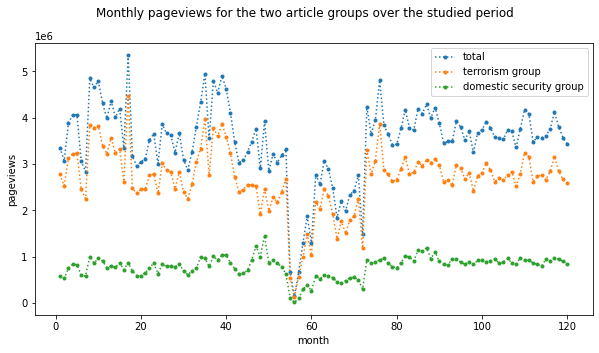

In [40]:
fig = plt.figure(figsize=(10, 5))

ax = monthly_views.sum().plot(fig=fig, style='.:', label='total')
terrorism_views.sum().plot(fig=fig, style='.:', label='terrorism group')
domestic_views.sum().plot(fig=fig, style='.:', label='domestic security group')

ax.set_xlabel('month')
ax.set_ylabel('pageviews')
plt.legend()
fig.suptitle('Monthly pageviews for the two article groups over the studied period');

We can see a strange drop of pageviews around month 55 (July 2014), let's try to understand it.

In [41]:
# We count the number of zeros for each article for each month
df['zeros'] = (df['views'] == 0).astype(int)
zeroes = df.groupby(['article', 'time'])['zeros'].mean().reset_index().pivot_table(index='article', columns='time', values='zeros')

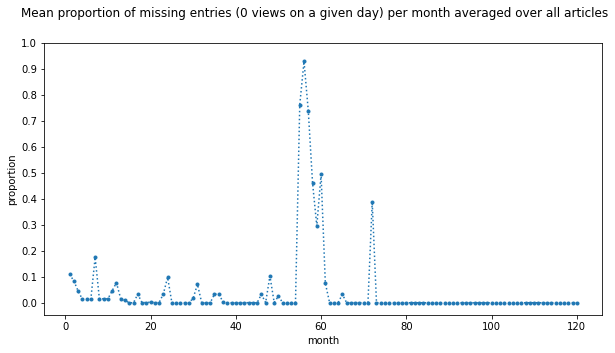

In [42]:
fig = plt.figure(figsize=(10, 5))

ax = zeroes.mean().plot(fig=fig, style='.:')

ax.set_xlabel('month')
ax.set_ylabel('proportion')
ax.set_yticks([i / 10 for i in range(11)])
fig.suptitle('Mean proportion of missing entries (0 views on a given day) per month averaged over all articles');

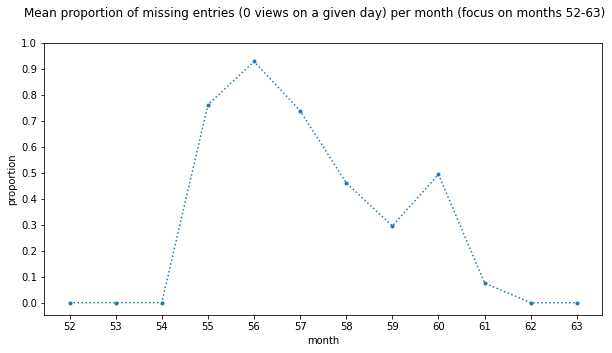

In [43]:
fig = plt.figure(figsize=(10, 5))

ax = zeroes.mean().loc[52:63].plot(fig=fig, style='.:')

ax.set_xlabel('month')
ax.set_xticks(range(52, 63+1))
ax.set_ylabel('proportion')
ax.set_yticks([i / 10 for i in range(11)])
fig.suptitle('Mean proportion of missing entries (0 views on a given day) per month (focus on months 52-63)');

This sudden increase in missing entries might be due to a Wikipedia outage during the months 54 to 60 (June to December 2014).

In any case, we will not consider these months during our analysis as this would surely affect the results. To do so, in the regression we will simply drop the entries corresponding to the mentioned months, without shifting the month numbers after them.

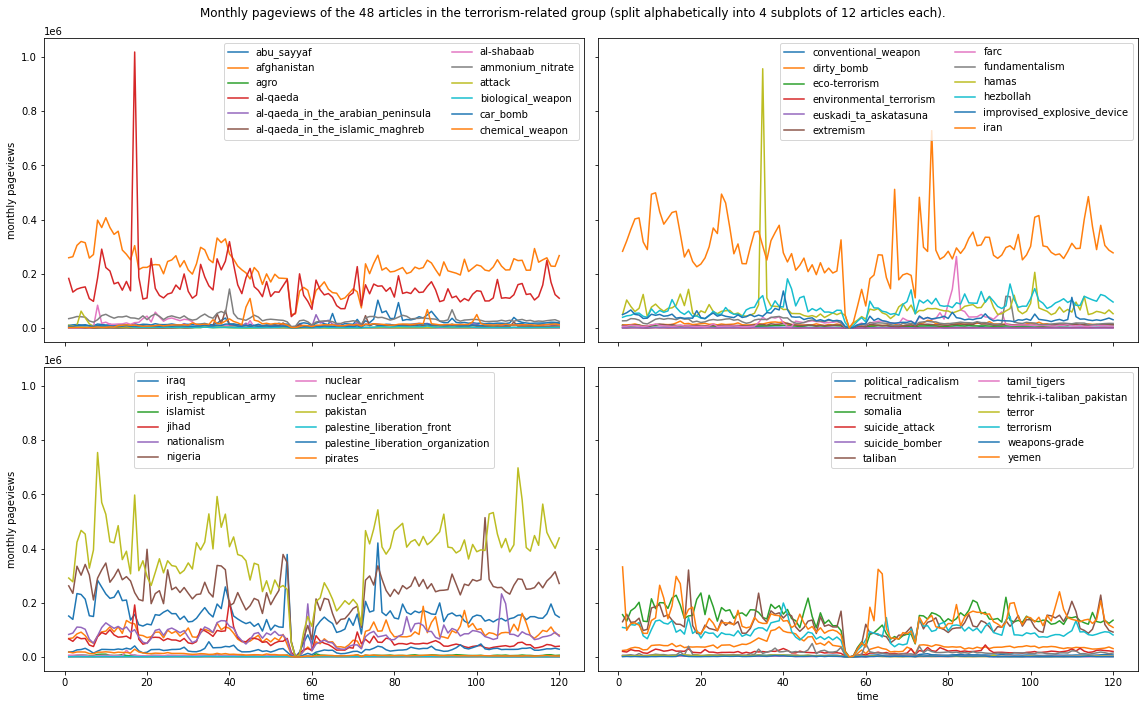

In [44]:
fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(16, 10))

terrorism_views.T.iloc[:,  0: 12].plot(ax=axes[0, 0])
terrorism_views.T.iloc[:, 12: 24].plot(ax=axes[0, 1])
terrorism_views.T.iloc[:, 24: 36].plot(ax=axes[1, 0])
terrorism_views.T.iloc[:, 36: 48].plot(ax=axes[1, 1])

axes[0, 0].set_ylabel('monthly pageviews')
axes[1, 0].set_ylabel('monthly pageviews')

axes[0, 0].legend(ncol=2)
axes[1, 0].legend(ncol=2)
axes[0, 1].legend(ncol=2)
axes[1, 1].legend(ncol=2)

fig.suptitle('Monthly pageviews of the 48 articles in the terrorism-related group'
             ' (split alphabetically into 4 subplots of 12 articles each).')

fig.set_tight_layout(True)

As we can see, there is a spike of pageviews for `al-qaeda` on around month 17 (May 2011, when Al-Qaeda's emir Osama bin Laden was killed), and for `hamas` around month 34 (October 2012, during the Operation "Pillar of Defense" conflict).

Since these mediatized events are expected to increase the number of pageviews, and have little to do with chilling effects, we will not consider them in our analysis.

In [45]:
terrorism_clean = terrorism_views.drop(['hamas', 'al-qaeda'])

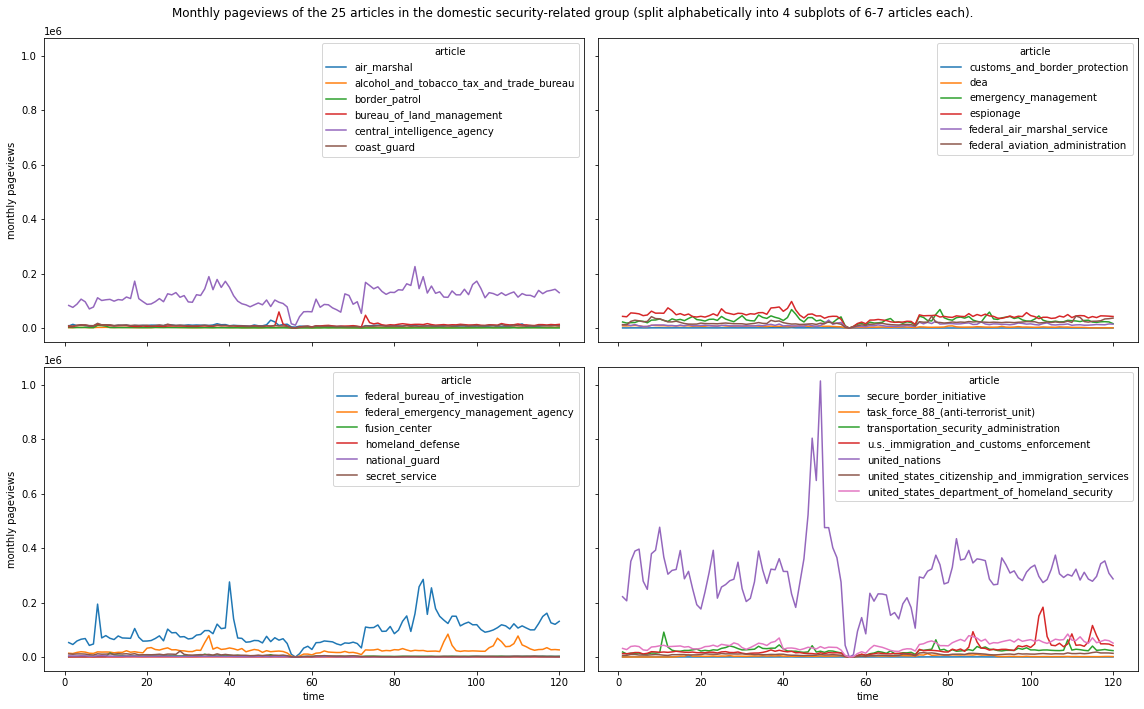

In [46]:
fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(16, 10))

domestic_views.T.iloc[:,  0:  6].plot(ax=axes[0, 0])
domestic_views.T.iloc[:,  6: 12].plot(ax=axes[0, 1])
domestic_views.T.iloc[:, 12: 18].plot(ax=axes[1, 0])
domestic_views.T.iloc[:, 18: 25].plot(ax=axes[1, 1])

axes[0, 0].set_ylabel('monthly pageviews')
axes[1, 0].set_ylabel('monthly pageviews')


fig.suptitle('Monthly pageviews of the 25 articles in the domestic security-related group'
             ' (split alphabetically into 4 subplots of 6-7 articles each).')

fig.set_tight_layout(True)

We can see that `united_nations` has considerably more views than the other topics, with a spike around month 50 (February 2014, we can't explain it). We will not consider this article for our analysis to remove oscillations due only to it.

In [47]:
domestic_clean = domestic_views.drop('united_nations')

## Exploring the Google Trends Data

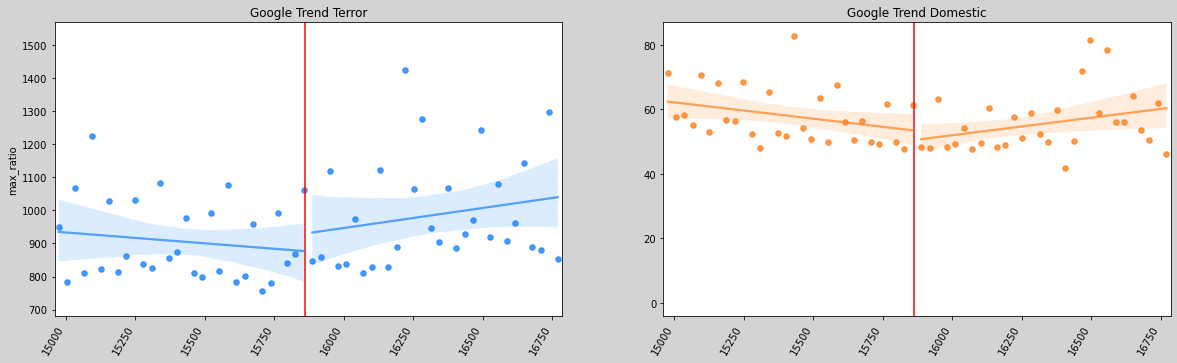

In [48]:
monthly_interest = google.groupby(['article', 'month', 'topic']).sum().reset_index().set_index('month')
terror = monthly_interest.loc[monthly_interest.topic == 'terror'].groupby('month').sum()
domestic = monthly_interest.loc[monthly_interest.topic == 'domestic'].groupby('month').sum()
split_timeseries_figures([terror, domestic],
                        names=['Google Trend Terror', 'Google Trend Domestic'],
                        keyword='max_ratio',
                        figsize=[20, 6],
                        same_plot=False,
                        sharey=False,
                        colors={'Google Trend Terror': [0.1, 0.5, 1, 0.7],
                               'Google Trend Domestic': [1, 0.5, 0.1, 0.7]})

The first impression is, there are no extreme outliers in the queried data when cumulated, but better let's have a look at the single articles. Note that, in the following plot, for the sake of an easier outlier detection, the plot are not on equal scale:

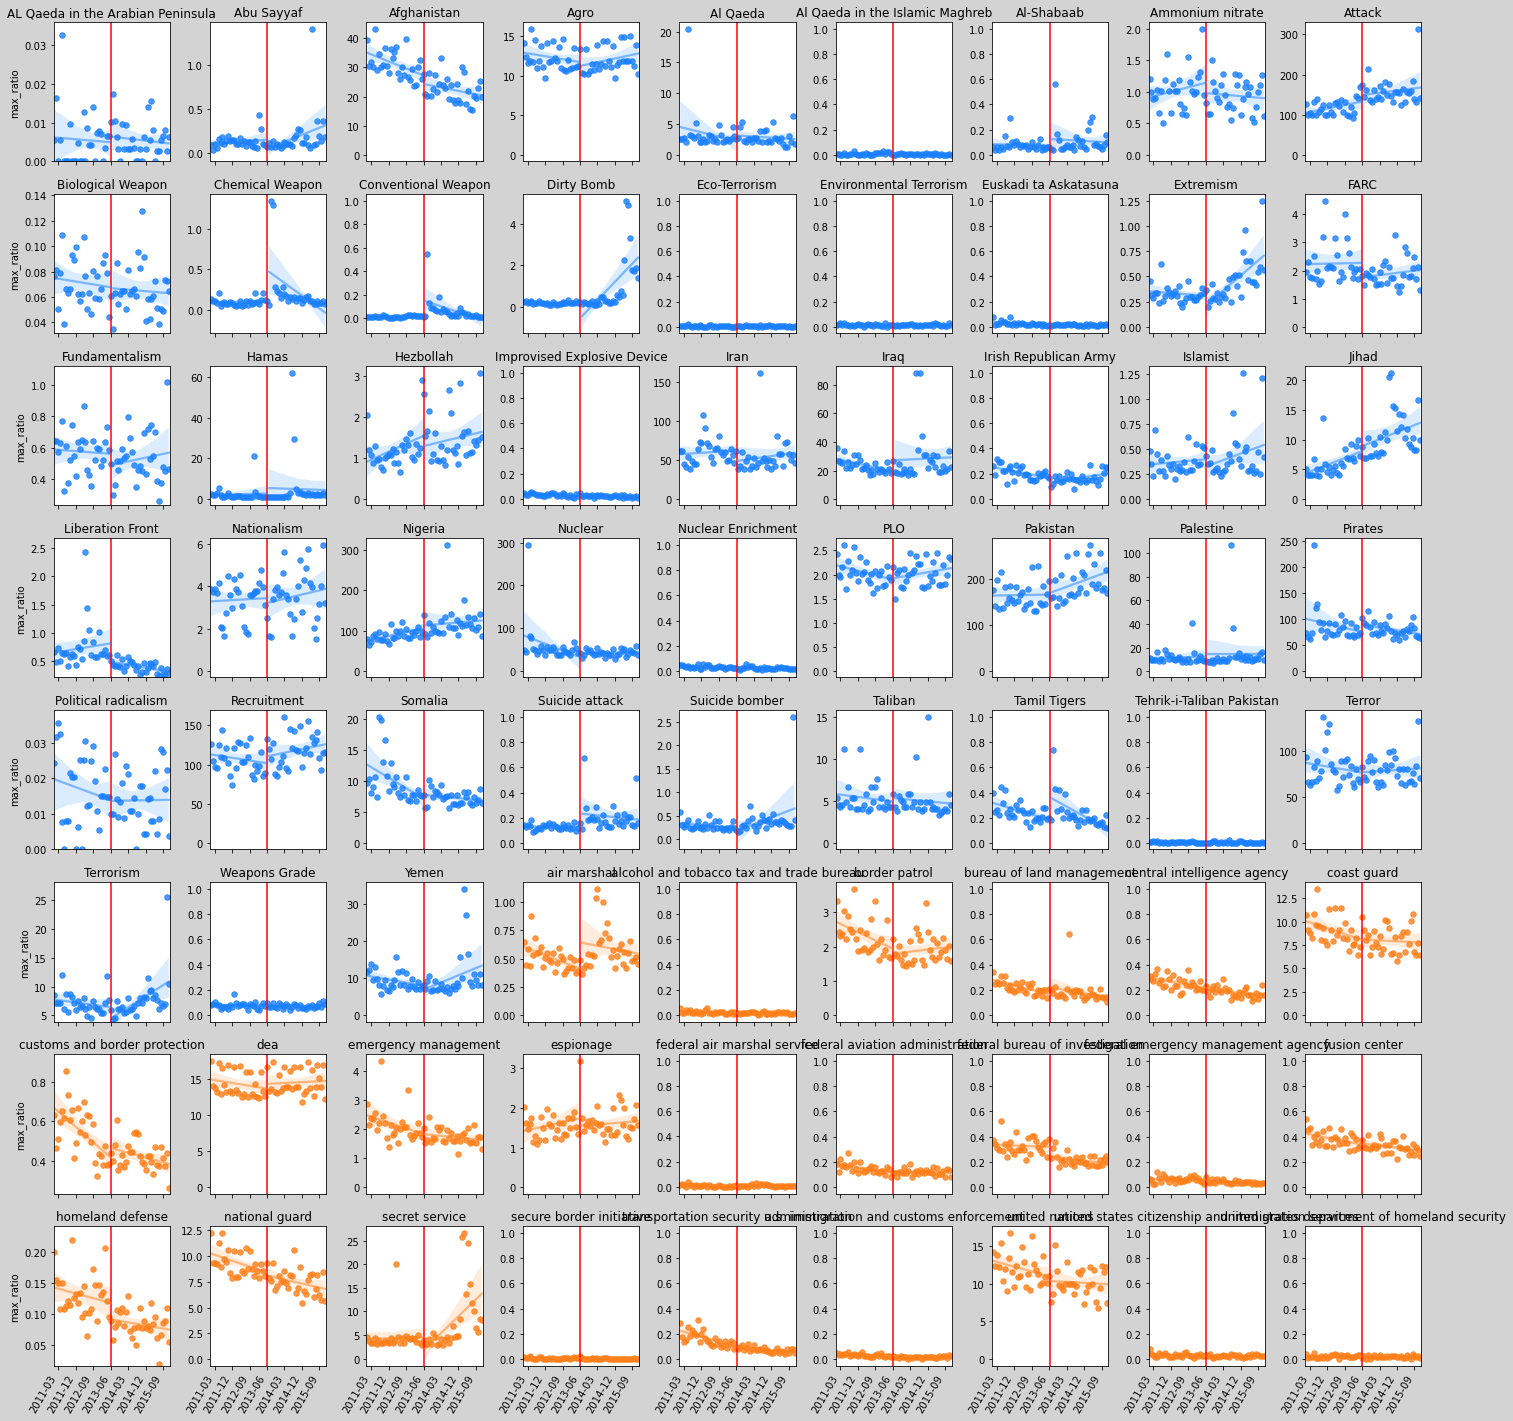

In [53]:
colors = {name: [0.1, 0.5, 1, 0.5] for name in monthly_interest.loc[monthly_interest.topic == 'terror'].article.unique()}
colors.update({name: [1, 0.5, 0.1, 0.5] for name in monthly_interest.loc[monthly_interest.topic == 'domestic'].article.unique()})
split_timeseries_figures(in_frames=[monthly_interest.loc[monthly_interest.article == article] for article in monthly_interest.article.unique()],
                         names=monthly_interest.article.unique(),
                         keyword='max_ratio',
                         same_plot=False,
                         legend=False,
                         figsize=[20, 20],
                         log=True,
                         sharey=False,
                         colors=colors)
plt.tight_layout()

## Regression

In [21]:
# DataFrame to apply the ITS analysis to
its = pd.DataFrame()

# Monthly number of views aggregated over the 46 terrorism articles
its['terrorism_views'] = terrorism_clean.sum()
# Monthly number of views aggregated over the 24 domestic articles
its['domestic_views'] = domestic_clean.sum()

# Indicator of whether the NSA revelations have already happened (month 42 is June 2013)
its['NSA'] = (its.index.to_series() >= 42).astype(int)
# We just do this to be able to use the column 'month' in the regression
its['month'] = its.index
its.head(3)

,terrorism_views,domestic_views,NSA,month
time,,,,
1,2543555,357822,0,1
2,2300062,329104,0,2
3,2902618,407211,0,3


In [22]:
terrorism_regr = smf.ols(formula='terrorism_views ~ month * NSA', data=its.drop(range(54, 60+1))).fit()
print(terrorism_regr.summary())
its['terrorism_regr'] = terrorism_regr.predict(its)
its[['terrorism_lower', 'terrorism_upper']] = terrorism_regr.get_prediction(its).summary_frame(alpha=0.05).iloc[:, 2:4].values

                            OLS Regression Results                            
Dep. Variable:        terrorism_views   R-squared:                       0.246
Model:                            OLS   Adj. R-squared:                  0.225
Method:                 Least Squares   F-statistic:                     11.85
Date:                Thu, 10 Dec 2020   Prob (F-statistic):           8.93e-07
Time:                        14:20:20   Log-Likelihood:                -1621.5
No. Observations:                 113   AIC:                             3251.
Df Residuals:                     109   BIC:                             3262.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2.744e+06   1.34e+05     20.526      0.0

In [23]:
domestic_regr = smf.ols(formula='domestic_views ~ month * NSA', data=its.drop(range(54, 60+1))).fit()
print(domestic_regr.summary())
its['domestic_regr'] = domestic_regr.predict(its)
its[['domestic_lower', 'domestic_upper']] = domestic_regr.get_prediction(its).summary_frame(alpha=0.05).iloc[:, 2:4].values

                            OLS Regression Results                            
Dep. Variable:         domestic_views   R-squared:                       0.411
Model:                            OLS   Adj. R-squared:                  0.395
Method:                 Least Squares   F-statistic:                     25.39
Date:                Thu, 10 Dec 2020   Prob (F-statistic):           1.56e-12
Time:                        14:20:20   Log-Likelihood:                -1450.8
No. Observations:                 113   AIC:                             2910.
Df Residuals:                     109   BIC:                             2921.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3.819e+05   2.95e+04     12.935      0.0

In [24]:
its

,terrorism_views,domestic_views,NSA,month,terrorism_regr,terrorism_lower,terrorism_upper,domestic_regr,domestic_lower,domestic_upper
time,,,,,,,,,,
1,2543555,357822,0,1,2.745027e+06,2.489591e+06,3.000464e+06,387132.024390,330716.367329,443547.681452
2,2300062,329104,0,2,2.746041e+06,2.500002e+06,2.992081e+06,392350.496341,338010.246148,446690.746535
3,2902618,407211,0,3,2.747056e+06,2.510276e+06,2.983836e+06,397568.968293,345273.776392,449864.160194
4,3016457,453161,0,4,2.748070e+06,2.520395e+06,2.975744e+06,402787.440244,352503.255094,453071.625394
5,3009786,431957,0,5,2.749084e+06,2.530341e+06,2.967827e+06,408005.912195,359694.429793,456317.394597
...,...,...,...,...,...,...,...,...,...,...
116,2627241,615685,1,116,2.710313e+06,2.537573e+06,2.883052e+06,641979.504564,603828.387767,680130.621361
117,2854994,623244,1,117,2.719408e+06,2.543071e+06,2.895745e+06,645563.582510,606617.773443,684509.391577
118,2628558,599062,1,118,2.728504e+06,2.548535e+06,2.908472e+06,649147.660456,609399.809429,688895.511482


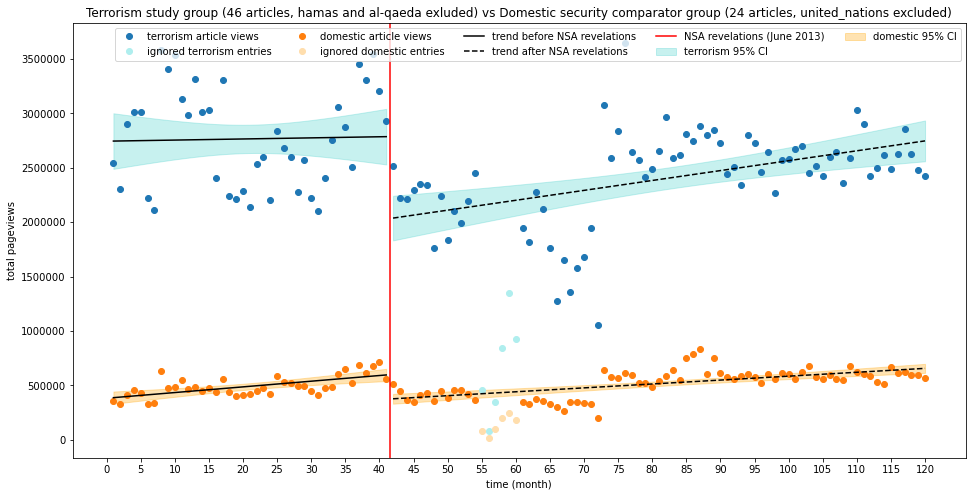

In [25]:
plt.figure(figsize=(16, 8))
plt.ticklabel_format(axis='y', style='plain')

# Plot the actual monthly pageviews as dots
plt.plot(its['terrorism_views'].drop(range(55, 60+1)), 'o', label='terrorism article views')
plt.plot(its['terrorism_views'].loc[55:60], 'o', color='paleturquoise', label='ignored terrorism entries')

# Plot the actual monthly pageviews as dots
plt.plot(its['domestic_views'].drop(range(55, 60+1)), 'o', label='domestic article views')
plt.plot(its['domestic_views'].loc[55:60], 'o', color='navajowhite', label='ignored domestic entries')

# Plot the regression line before the June 2013 revelations (June 2013 excluded)
plt.plot(its.loc[:41, 'terrorism_regr'], 'k-', label='trend before NSA revelations')
# Plot the regression line after the June 2013 revelations (June 2013 included)
plt.plot(its.loc[42:, 'terrorism_regr'], 'k--', label='trend after NSA revelations')

# Plot the regression line before the June 2013 revelations (June 2013 excluded)
plt.plot(its.loc[:41, 'domestic_regr'], 'k-')
# Plot the regression line after the June 2013 revelations (June 2013 included)
plt.plot(its.loc[42:, 'domestic_regr'], 'k--')

# Plot the regression confidence intervals
plt.fill_between(its.loc[:41].index, its.loc[:41]['terrorism_lower'], its.loc[:41]['terrorism_upper'],
                 alpha=0.3, color='mediumturquoise', label='terrorism 95% CI')
plt.fill_between(its.loc[42:].index, its.loc[42:]['terrorism_lower'], its.loc[42:]['terrorism_upper'],
                 alpha=0.3, color='mediumturquoise')

plt.fill_between(its.loc[:41].index, its.loc[:41]['domestic_lower'], its.loc[:41]['domestic_upper'],
                 alpha=0.3, color='orange', label='domestic 95% CI')
plt.fill_between(its.loc[42:].index, its.loc[42:]['domestic_lower'], its.loc[42:]['domestic_upper'],
                 alpha=0.3, color='orange')

# Show the moment of the NSA revelations
plt.axvline(x=41.5, color='r', label='NSA revelations (June 2013)')

# Show legend, set title, axis labels, x ticks
plt.legend(ncol=5)
plt.title('Terrorism study group (46 articles, hamas and al-qaeda exluded)'
          ' vs Domestic security comparator group (24 articles, united_nations excluded)')
plt.xlabel('time (month)')
plt.xticks(range(0, 120+1, 5))
plt.ylabel('total pageviews');